# Classification

Classification in a supervised learning task along with regression. It is used in predicting classes i.e. it is used to predict categorical data.
In this notebook the following topics will be covered: -
1. Using MNIST Dataset
2. Training a Binary Classifier
3. Performance Measures
4. Multiclass Classification
5. Error Analysis
6. Multilabel Classification
7. Multioutput Classification

## 1. Using MNIST Dataset

The dataset we will be using for classification is the MNIST dataset, which is a set of 70,000 small images of handwritten digits. Each image is labelled with the digit it represents. This dataset is often used as a way of seeing how new classification algorithms perform.

Scikit-Learn provides many helper functions to download popular datasets. MNIST is one of them. The following code fetches the MNIST dataset.

In [2]:
from sklearn.datasets import fetch_openml

# Used to fetch data from openml using the name or dataset id
mnist = fetch_openml('mnist_784', version=1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

Datasets loaded by Scikit learn generally have a similar dictionary structure, including the following:
* A **DESCR** key describing the dataset
* A **data** key containing an array with one row per instance and one column per feature
* A **target** key containing an array with the labels.

In [7]:
X, y = mnist["data"], mnist["target"]
X.shape, y.shape

((70000, 784), (70000,))

This shows that there are 70,000 images and each image has 784 features. This is because each image has 28 * 28 pixels, and each feature represents the pixels' intensity.
To see one image we will need to plot it as if we use it normally it will only give us the numeric values.

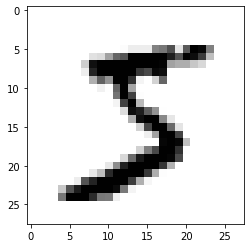

In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

img = X.loc[0].to_numpy()
img = img.reshape(28, 28)
plt.imshow(img, cmap="binary")

This looks like a 5 and if we check our target it is indeed a 5

In [33]:
y[0]

'5'

We need to convert this y to an integer in the following manner

In [39]:
y = y.astype(np.uint8)
y[0]

5

Let us now just create a function that we can use to view a random image from X

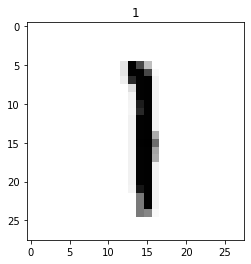

In [42]:
import random

def plot_random_digit():
    num = random.randint(0, len(X))
    random_img = X.loc[num].to_numpy()
    random_img = random_img.reshape(28, 28)
    plt.imshow(random_img, cmap="binary")
    plt.title(y[num])

plot_random_digit()

We need to now create our train and test set, MNIST already has shuffled the order for us normally this is not the case, and so we will have to do it ourselves however in this scenario we can use it directly.
Shuffling is important as some learning algorithms are sensitive to the order of training instances and will perform poorly if they get many similar training instances in a row.

In [43]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]
len(X_train), len(X_test)

(60000, 10000)

## 2. Training a Binary Classifier